In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
#import seaborn as sns
import sympy as sym
from scipy import constants as const


In [181]:
data_base = pd.read_csv("tab.csv", delimiter=';')
data1 = pd.DataFrame()
data2 = pd.DataFrame()
data3 = pd.DataFrame()

data1[['f','I']] = data_base[['f_1','I_1']].dropna()
data2[['f','I']] = data_base[['f_2','I_2']].dropna()
data3[['f','I']] = data_base[['f_3','I_3']].dropna()

datas = [data1, data2, data3]

for data in datas:
    data['I'] *= 1e-3 #mA -> A

R1 = 55.2
R2 = 97.1
R3 = 266.6

L2 = 20e-3      #mH -> H 
C2 = 101.9e-9   #nF -> F

U0 = 3.001

U1 = 11.26
U2 = 8.15
U3 = 3.116


data3

,f,I
0,100,0.00012
1,300,0.00059
2,500,0.00093
3,700,0.00130
4,900,0.00168
...,...,...
59,6200,0.00162
60,6600,0.00101
61,7000,0.00056
62,7400,0.00030


In [ ]:
def calc_uA(series):
    s = 0
    mean = series.mean()
    for x in series:
        s += (x - mean)**2
    s /= len(series)*(len(series)-1)
    return np.sqrt(s)

def calc_uB(Deltas):
    s = 0
    for D in Deltas:
        s += D**2 / 3
    return np.sqrt(s)

def calc_Dp_multimetr_R(rdg,dgt):
    return 0.5/100 * rdg + 2 * dgt

def calc_Dp_multimetr_C(rdg, dgt):
    return 5/100 * rdg + 10 * dgt

def calc_Dp_multimetr_U(rdg, dgt, res):
    ret = {4 : 0.8/100 * rdg + 3 * dgt, 40 : 2.5/100 * rdg + 5 * dgt}
    return ret[res]

def calc_Dp_multimetr_I(rdg, dgt):
    return 1/100 * rdg + 10 * dgt

def calc_Dp_f(rdg):
    if rdg < 1000:
        return 1e-6
    else:
        return 1e-5

In [184]:
data = data1
for data in datas:
    data['uf'] = data.apply(lambda row : calc_uB([ calc_Dp_f(row['f']) ]), axis=1 )
    data['uI'] = data.apply(lambda row : calc_uB([ calc_Dp_multimetr_I(row['I'], 0.01e-3) ]), axis=1)

uR1 = calc_uB([calc_Dp_multimetr_R(R1, 0.1)])
uR2 = calc_uB([calc_Dp_multimetr_R(R2, 0.1)])
uR3 = calc_uB([calc_Dp_multimetr_R(R3, 0.1)])

uL2 = 0.1 * L2

uC2 = calc_uB([ calc_Dp_multimetr_C(C2, 0.1e-9) ])

uU0 = calc_uB([ calc_Dp_multimetr_U(U0, 0.001, 4) ])

uU1 = calc_uB([ calc_Dp_multimetr_U(U1, 0.01, 40) ])
uU2 = calc_uB([ calc_Dp_multimetr_U(U2, 0.01, 40) ])
uU3 = calc_uB([ calc_Dp_multimetr_U(U3, 0.001, 4) ])


data1.head()

,f,I,uf,uI
0,100.0,0.00013,0.0000005774,0.0000584856
1,300.0,0.00058,0.0000005774,0.0000610837
2,500.0,0.00094,0.0000005774,0.0000631621
3,700.0,0.00132,0.0000005774,0.0000653561
4,900.0,0.00172,0.0000005774,0.0000676655


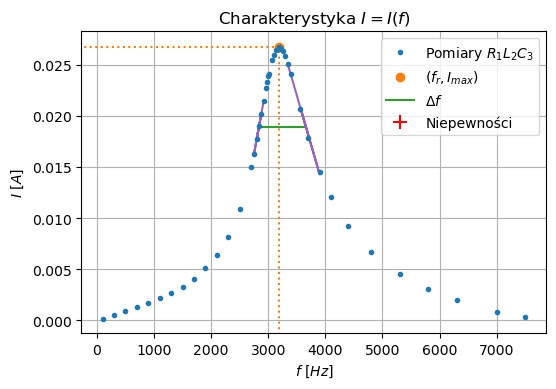

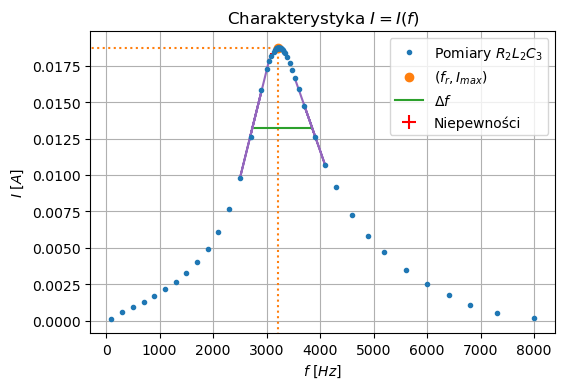

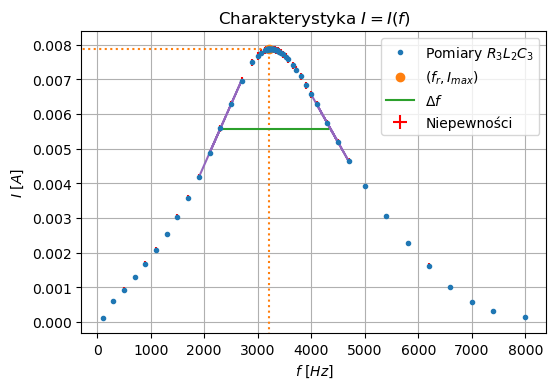

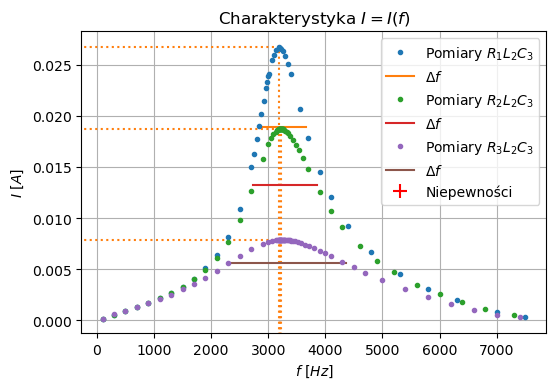

In [186]:
def plot_I_f(data, UC, uUC, i, show=True):
    plt.rcParams['figure.dpi'] = 100
    x = data['f']
    y = data['I']
    xerr = data['uf']
    yerr = data['uI']

    plt.plot(x, y, '.', label='Pomiary $R_{:d}L_2C_3$'.format(i), zorder=3)
    if show or i==1:
        plt.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, fmt="none", label='Niepewności', color='red')
    else:
        plt.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, fmt="none", color='red')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())

    #częstotliwość rezonansowa
    f_r = x[y==y.max()].iloc[0]
    uf_r = xerr[y==y.max()].iloc[0]

    if show:
        plt.plot(f_r, y.max(), 'o', label='$(f_r, I_{max})$')

    plt.plot(np.ones(10) * f_r, np.linspace(-0.1, y.max(), 10), ":", color="C1")
    plt.plot(np.linspace(-1000, f_r, 10), np.ones(10) * y.max(), ":", color="C1")

    #pojemność kondensatora
    C = 1 / (2*const.pi * f_r)**2 / L2
    u_CC = 1 / (2*const.pi**2) * np.sqrt((uL2/(2 * f_r**2 * L2**2))**2 + (uf_r/(f_r**3 * L2))**2)

    #współczynnik dobroci
    QU = UC / U0
    u_CQU = np.sqrt((uUC / U0)**2 + (UC * uU0 / U0**2)**2)

    #wsółczynnik dobroci na podstaw. wykresu
    I_sqrt2 = y.max() / np.sqrt(2)
    uI_sqrt2 = np.sqrt((1/np.sqrt(2))**2 * yerr.loc[y==y.max()].iloc[0]**2)

    yl = y.loc[x<f_r]
    yr = y.loc[x>f_r]

    #Delta f
    ind_l = (yl-I_sqrt2).abs().sort_values().index[0:5]
    ind_r = (yr-I_sqrt2).abs().sort_values().index[0:5]


    # dx_dy_l = (x.loc[ind_l].sort_index().iloc[1] - x.loc[ind_l].sort_index().iloc[0]) / (y.loc[ind_l].sort_index().iloc[1] - y.loc[ind_l].sort_index().iloc[0])
    # dx_dy_r = (x.loc[ind_r].sort_index().iloc[1] - x.loc[ind_r].sort_index().iloc[0]) / (y.loc[ind_r].sort_index().iloc[1] - y.loc[ind_r].sort_index().iloc[0])

    # # udx_dy_l = np.sqrt((1 / (y.loc[ind_l].sort_index().iloc[1] - y.loc[ind_l].sort_index().iloc[0])) ** 2 * xerr.loc[ind_l].sort_index().iloc[1]** 2 + (-1 / (y.loc[ind_l].sort_index().iloc[1] - y.loc[ind_l].sort_index().iloc[0])) ** 2 * xerr.loc[ind_l].sort_index().iloc[0]**2 + ((x.loc[ind_l].sort_index().iloc[1] - x.loc[ind_l].sort_index().iloc[0]) / (y.loc[ind_l].sort_index().iloc[1] - y.loc[ind_l].sort_index().iloc[0]) ** 2) ** 2 * yerr.loc[ind_l].sort_index().iloc[1]** 2 + ((x.loc[ind_l].sort_index().iloc[1] - x.loc[ind_l].sort_index().iloc[0]) / (y.loc[ind_l].sort_index().iloc[1] - y.loc[ind_l].sort_index().iloc[0]) ** 2) ** 2* yerr.loc[ind_l].sort_index().iloc[0]**2)

    # f1 = x.loc[ind_l].iloc[0] + (I_sqrt2 - y.loc[ind_l].iloc[0]) * dx_dy_l
    # f2 = x.loc[ind_r].iloc[0] + (I_sqrt2 - y.loc[ind_r].iloc[0]) * dx_dy_r

    p_l, V_l = np.polyfit(x.loc[ind_l], y.loc[ind_l], deg=1, cov=True)
    f1 = (I_sqrt2 - p_l[1]) / p_l[0]
    uf1 = np.sqrt((1 / p_l[0])**2 * uI_sqrt2**2 + (-(I_sqrt2 - p_l[1]) / p_l[0]**2)**2 * V_l[0][0] + (-1/p_l[0])**2 * V_l[1][1])

    p_r, V_r = np.polyfit(x.loc[ind_r], y.loc[ind_r], deg=1, cov=True)
    f2 = (I_sqrt2 - p_r[1]) / p_r[0]
    uf2 = np.sqrt((1 / p_r[0])**2 * uI_sqrt2**2 + (-(I_sqrt2 - p_r[1]) / p_r[0]**2)**2 * V_r[0][0] + (-1/p_r[0])**2 * V_r[1][1])

    # uf1 = np.sqrt( (1)**2 * xerr.loc[ind_l].iloc[0]**2 + (dx_dy_l / np.sqrt(2))** * yerr.loc[y==y.max()].iloc[0]**2 + (dx_dy_l)**2 * yerr.loc[ind_l].iloc[0]**2 + (I_sqrt2 - y.loc[ind_l].iloc[0])**2 * udx_dy_l**2)


    plt.plot(np.linspace(f1, f2, 10), np.ones(10) * I_sqrt2, "-", label="$\Delta f$")
    if show:
        plt.plot(x.loc[ind_l], x.loc[ind_l] * p_l[0] + p_l[1], color="C4")
        plt.plot(x.loc[ind_r], x.loc[ind_r] * p_r[0] + p_r[1], color="C4")

    Delta_f = f2 - f1
    uDelta_f = np.sqrt((1)**2 * uf1**2 + (1)**2 * uf2**2)


    Qf = f_r / Delta_f
    uQf = np.sqrt( (1 / Delta_f)**2 * uf_r**2 + (-f_r / Delta_f**2)**2 * uDelta_f**2)



    plt.title("Charakterystyka $I = I(f)$")
    plt.xlabel('$f\ [Hz]$')
    plt.ylabel('$I\ [A]$')
    plt.grid(b=True, axis='both')
    
    if show==True:
        plt.legend()
        plt.savefig("I_f_{:d}.png".format(i), dpi=600, bbox_inches='tight')
        plt.show()
    ret = pd.Series()
    ret['f_r'] = f_r
    ret['uf_r'] = uf_r
    ret['I_max'] = y.max()
    ret['uI_max'] = yerr.loc[y==y.max()].iloc[0]
    ret['C'] = C
    ret['u_CC'] = u_CC
    ret['QU'] = QU
    ret['u_CQU'] = u_CQU
    ret['I_sqrt2'] = I_sqrt2
    ret['uI_sqrt2'] = uI_sqrt2
    ret['a_l'] = p_l[0]
    ret['ua_l'] = np.sqrt(V_l[0][0])
    ret['b_l'] = p_l[1]
    ret['ub_l'] = np.sqrt(V_l[1][1])
    ret['a_r'] = p_r[0]
    ret['ua_r'] = np.sqrt(V_r[0][0])
    ret['b_r'] = p_r[1]
    ret['ub_r'] = np.sqrt(V_r[1][1])
    ret['f_1'] = f1
    ret['uf_1'] = uf1
    ret['f_2'] = f2
    ret['uf_2'] = uf2
    ret['Delta_f'] = Delta_f
    ret['uDelta_f'] = uDelta_f
    ret['Qf'] = Qf
    ret['uQf'] = uQf
    return ret

data0 = pd.DataFrame()
for data, UC, uUC, i in zip(datas, [U1, U2, U3], [uU1, uU2, uU3], range(1,4)):
    data0[i] = plot_I_f(data, UC, uUC, i)

for data, UC, uUC, i in zip(datas, [U1, U2, U3], [uU1, uU2, uU3], range(1,4)):
    plot_I_f(data, UC, uUC, i, show=False)
plt.legend()
plt.savefig("I_f_123.png", dpi=600, bbox_inches='tight')
plt.show()

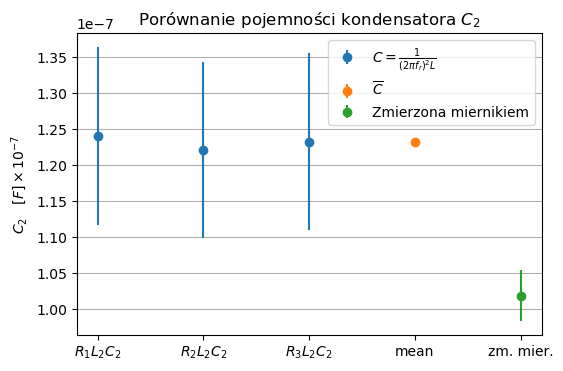

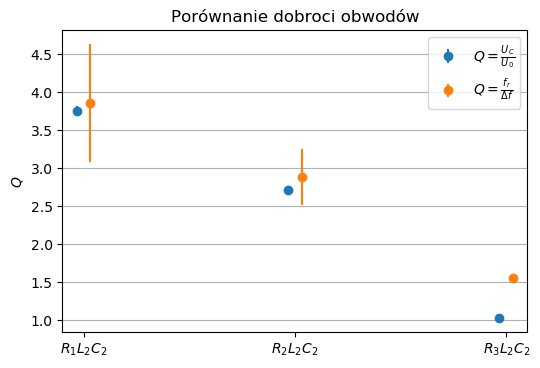

In [188]:
plt.rcParams['figure.dpi'] = 100

offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

x = ["$R_1 L_2 C_2$", "$R_2 L_2 C_2$", "$R_3 L_2 C_2$"]
plt.errorbar(x=x, y=data0.loc['QU'], yerr=data0.loc['u_CQU'], fmt="o", transform=trans+offset(-5), label=r"$Q=\frac{U_C}{U_0}$")
plt.errorbar(x=x, y=data0.loc['Qf'], yerr=data0.loc['uQf'], fmt="o", transform=trans+offset(5), label=r"$Q=\frac{f_r}{\Delta f}$")

plt.title("Porównanie dobroci obwodów")
plt.ylabel("$Q$")
plt.legend(labels=[r"$Q=\frac{U_C}{U_0}$", r"$Q=\frac{f_r}{\Delta f}$"])
plt.grid(b=True, axis="y")
plt.savefig("dobroc_Q.png", dpi=600, bbox_inches='tight')
plt.show()

In [189]:
pd.set_option('precision', 10)
wynik0 = pd.DataFrame()
wynik0 = data0.copy()



wynik3 = pd.DataFrame()
wynik3[["$f$", "$u(f)$", "$I$", "$u(I)$"]] = data3[["f", "uf", "I", "uI"]].copy()

wynik = wynik3

def dollar(ls):
    ret = {}
    for i in ls:
        ret[i] = ("$" + i + "$")
    return ret

def parser(x):
    if x>=1000:
        return "{:.7f}".format(x)
    elif x>=100:
        return "{:.8f}".format(x)
    elif x<1e-6:
        return "{:.8f}".format(x)
    elif x<1e-5 :
        return "{:.7f}".format(x)
    elif x<1e-4 and 1e-5<=x:
        return "{:.6f}".format(x)    
    else:
        return str(x)

def round_2significant(x, u):
    i = 0
    while (u <= 10):
        u *= 10
        i += 1
    while (100 < u):
        u *= 0.1
        i -= 1
    #now 10 <= u < 100
    ten_pow = 10 ** i
    u = np.ceil(u) / ten_pow
    if (x is not None):
        x = x.round(i+1)
    return x, u

wynik['$I$'] = wynik.apply(lambda row: round_2significant(x=row['$I$'], u=row['$u(I)$'])[0], axis=1)
wynik['$u(I)$'] = wynik.apply(lambda row: round_2significant(x=row['$I$'], u=row['$u(I)$'])[1], axis=1)
    

new_ind = dollar(wynik0.index)
wynik0 = wynik0.rename(new_ind)
#print(wynik.to_latex(escape=False, longtable=True, float_format=parser, caption="$R_2 L_2 C_2$", label="tab:2", index=False) )
wynik0


,1,2,3
$f_r$,3195.0000000000,3220.0000000000,3205.0000000000
$uf_r$,0.0000057735,0.0000057735,0.0000057735
$I_max$,0.0267000000,0.0187500000,0.0078800000
$uI_max$,0.0002118875,0.0001659882,0.0001032302
$C$,0.0000001241,0.0000001222,0.0000001233
$u_CC$,0.0000000124,0.0000000122,0.0000000123
$QU$,3.7520826391,2.7157614129,1.0383205598
$u_CQU$,0.0666892233,0.0508164443,0.0076141612
$I_sqrt2$,0.0188797511,0.0132582521,0.0055720014
$uI_sqrt2$,0.0001498271,0.0001173714,0.0000729948


In [190]:
f_r_mean = data0.loc['f_r'].mean()

uf_r_mean = calc_uA(data0.loc['f_r'])
print(f_r_mean, uf_r_mean)

C_m = 1 / (2*const.pi * f_r_mean)**2 / L2
u_CC_m = 1 / (2*const.pi**2) * np.sqrt((uL2/(2 * f_r_mean**2 * L2**2))**2 + (uf_r_mean/(f_r_mean**3 * L2))**2)
print(C_m, u_CC_m)

3206.6666666666665 7.264831572567789
1.231693453062854e-07 1.2329571803307825e-08


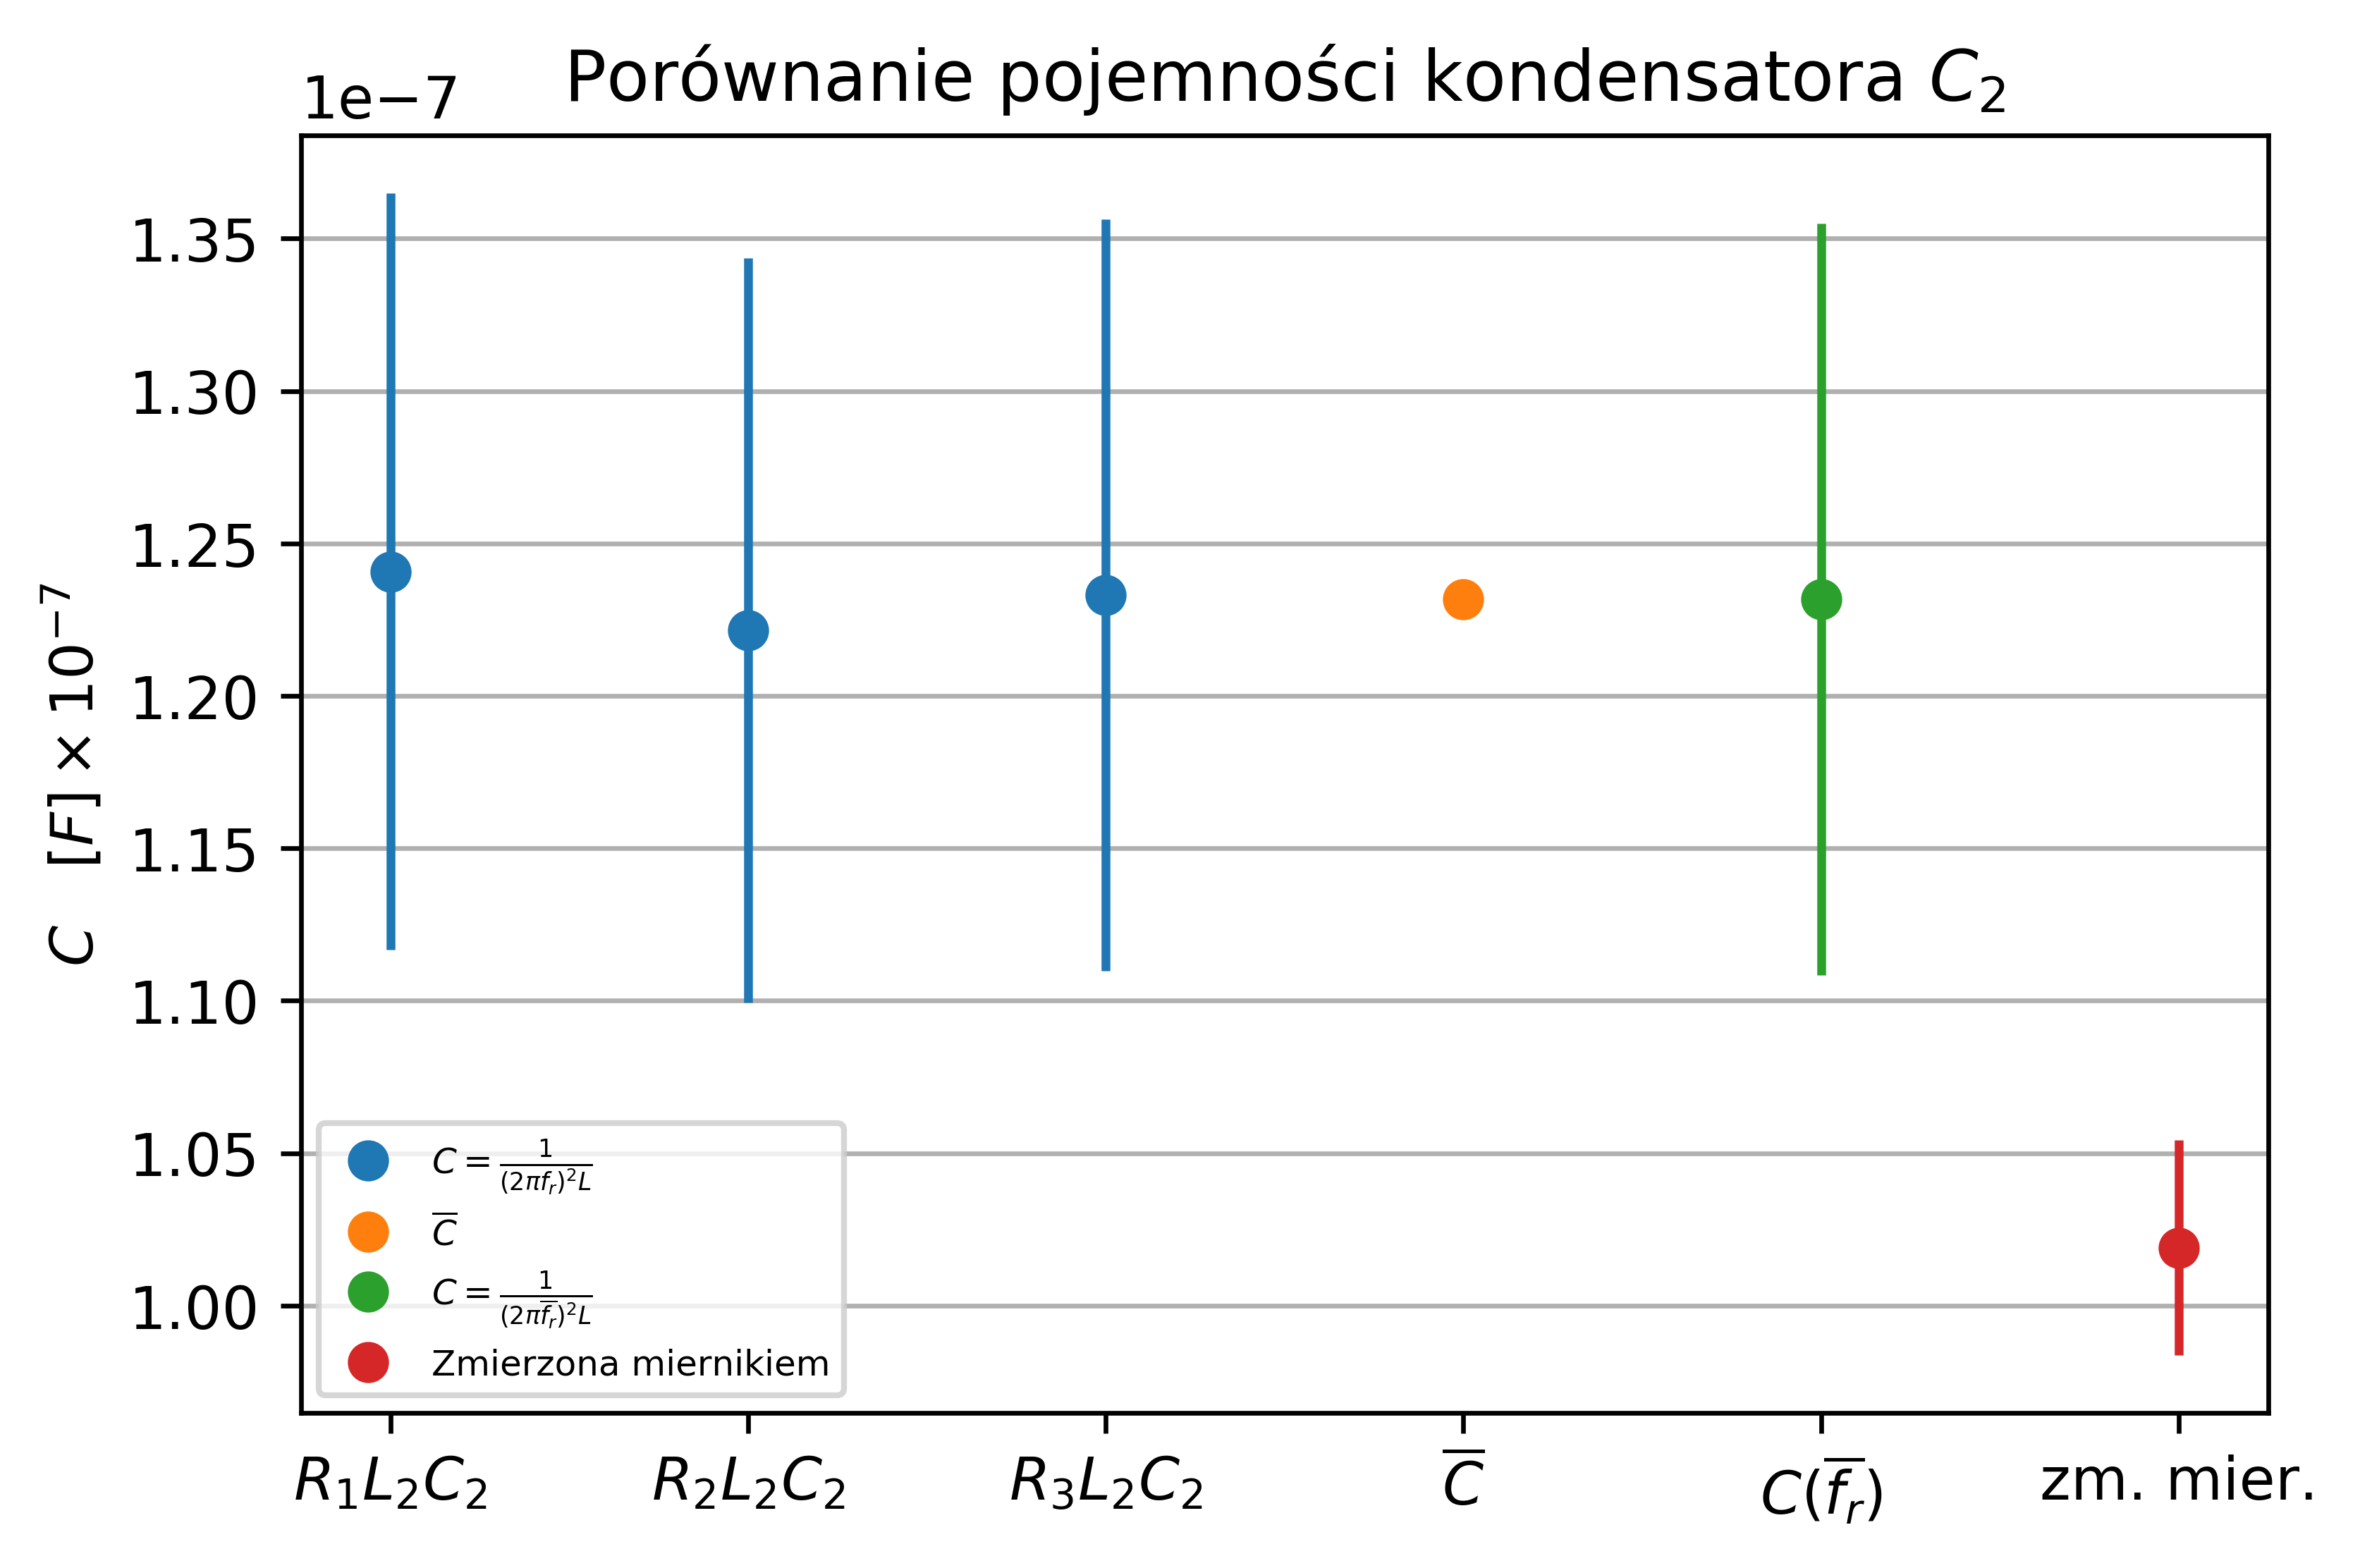

1.231693453062854e-07

In [197]:
data0
plt.rcParams['figure.dpi'] = 600
plt.errorbar(x=["$R_1 L_2 C_2$", "$R_2 L_2 C_2$", "$R_3 L_2 C_2$"], y=data0.loc['C'], yerr=data0.loc['u_CC'], fmt="o", label=r"$C=\frac{1}{(2\pi f_r)^2 L}$")

C_mean = data0.loc['C'].mean()

uC_mean = calc_uA(data0.loc['C'])
plt.errorbar(x=[r"$\overline{C}$"], y=[C_mean], yerr=uC_mean, fmt='o', label=r"$\overline{C}$")

plt.errorbar(x=[r'$C(\overline{f_r})$'], y=C_m, yerr=u_CC_m, fmt='o', label=r"$C=\frac{1}{(2\pi \overline{f_r})^2 L}$")

plt.errorbar(x=["zm. mier."], y=C2, yerr=uC2, fmt='o', label="Zmierzona miernikiem")

# plt.xlim(plt.xlim())
# plt.plot(np.linspace(-1,4,10), np.ones(10) * C2, color='C2')
# plt.fill_between(np.linspace(-1,4,10), np.ones(10) * C2+uC2, np.ones(10) * C2-uC2, alpha=0.5, color="C2")

plt.ylabel(r"$C\quad [F]\times 10^{-7}$")
plt.title("Porównanie pojemności kondensatora $C_2$")
plt.legend(prop={'size': 6}, loc=3)
plt.grid(b=True, axis="y")
plt.savefig("C_2.png", dpi=600, bbox_inches='tight')
plt.show()
uf_r_mean
C_m